# <center> Emoji Predictor - DL project, Dec. 2020

In [169]:
import emojis
from unidecode import unidecode
import string
import re
import ast
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import CamembertModel, CamembertTokenizer, CamembertForSequenceClassification
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Data acquisition

Thanks to to the Twitter API, we downloaded:
* ~4.5M raw tweets
* in French
* posted between September and December 2019
* containing emojis.

In [2]:
with open('/Users/Thomas/Downloads/emoji-predictor/tweets_fr.txt') as tweets:
    line1 = tweets.readline()
    line2 = tweets.readline()
    line3 = tweets.readline()
    counter = 3
    for x in tweets:
        counter += 1
    print(f'We have {counter} tweets. See examples below:\n')
    print(line1)
    print(line2)
    print(line3)

We have 4529208 tweets. See examples below:

@chlechevalier @agnesbuzyn @googlenews macron n a pas honte de faire la fête 🥳 , brizitte se dandine habillée par un grand couturier , et pendant ce temps - là , le peuple se meurt 😡 😡 😡 😡

@yoongichana la petite était blonde 5 ans jcp pk elle est morte mais j ’ habite au 3e étage et j ’ entendais qlq ’ 1 toqué à la fenêtre de ma chambre alors moi j ’ ouvre comme une conne et la son esprit était dans 1 ballon 🎈 le ballon explose tt est devenu noir en 1sec j ’ ai hurlé ma mère / sœur aussi

et vous ? 🥰 bonne année les amis ! 💃 twitterlink



## Pre-processing

We went through several preprocessing steps to clean the tweets, before we were able to feed them to CamemBERT for embeddings.

**1) Exclude spam / bots**

The first preprocessing step was to **exclude spamming and bots**, which often use multiple emojis without real meaning / relationship to the actual text. For that, we **deleted the tweets containing more than 5 emojis**, and we kept **only 1 tweet per single user id** (which avoids bots posting multiple spam tweets).

**2) Extract emojis to label tweets**

We **extracted the emojis** with regular expressions and the `emojis` package, in order to use them to label each tweet. A tweet will therefore be able to have **multiple labels**. We encode labels in the next section.

**3) Clean text**

Finally, to clean the raw text, we **removed tags (@ and # words)** and the 'twitterlink' word (corresponding to hyperlinks in the tweets), so that we have ready-to-tokenize text.

### Define and test the cleaning fuction

In [204]:
def clean(text):
    
    # lower text and remove accents
    text = unidecode(text.lower())

    # remove numbers, words starting with # or @, and 'twitterlink' words    
    text = re.sub(r'#\S+|@\S+|\d+|twitterlink', r'', text)
    
    # remove remaining punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # return text with single whitespaces
    return ' '.join(text.split())

In [5]:
# test on 3 tweets

test = ["@vita_despi je me tape 3 râleurs qui n '  arrêtent pas depuis 10mn !! #waiting 😓😓",
        " 2020 sera une année encore plus fruisissante 😉 le voyage commence ! 🛬 #quiabuboira 😜",
        "j ’ vais encore arrêter , encore 1 fois et je reprendrais plus 👍 twitterlink "]

output = []
for x in test:
    line = (clean(x), list(emojis.get(x)))
    output.append(line)
output

[('je me tape raleurs qui n arretent pas depuis mn', ['😓']),
 ('sera une annee encore plus fruisissante le voyage commence',
  ['😜', '🛬', '😉']),
 ('j vais encore arreter encore fois et je reprendrais plus', ['👍'])]

### Extract the 100 most common emojis

In [6]:
# clean a part of the dataset (10k), from which we will extract the most common emojis

with open('/Users/Thomas/Downloads/emoji-predictor/tweets_fr.txt') as tweets:
    with open('/Users/Thomas/Downloads/emoji-predictor/10k_tweets_labelled.txt', 'w') as output:
        N_TWEETS = 10000
        delim = ""
        counter = 0
        for tweet in tweets:
            if counter >= N_TWEETS: break
            line = (clean(tweet), list(emojis.get(tweet)))
            output.write(delim+str(line))
            delim = ",\n"
            counter += 1
            print(f'\r{counter}', end='')

10000

In [7]:
# get the 100 most common emojis

with open('/Users/Thomas/Downloads/emoji-predictor/10k_tweets_labelled.txt') as tweets:
    emoji_list = []
    for tweet in tweets:
        x = ast.literal_eval(tweet)
        emoji_list.extend(x[0][1])
    emoji_list = np.array(emoji_list)

unique, counts = np.unique(emoji_list, return_counts=True)
emoji_list = list(sorted(dict(zip(unique, counts)).items(), key=lambda item: item[1], reverse = True))
emoji_list = [x[0] for x in emoji_list]
emoji_list = emoji_list[:100]

with open('/Users/Thomas/Downloads/emoji-predictor/top100.txt', 'w') as output:
    output.write(str(emoji_list))
    
emoji_list

['😂',
 '😭',
 '👉',
 '😍',
 '🙏',
 '😉',
 '🔥',
 '🤣',
 '😅',
 '👍',
 '🎉',
 '💪',
 '🤔',
 '😊',
 '👌',
 '✨',
 '🥰',
 '😁',
 '😔',
 '👏',
 '😘',
 '😱',
 '🥺',
 '✅',
 '🙄',
 '👀',
 '💕',
 '🎶',
 '😀',
 '😌',
 '🤩',
 '😎',
 '😡',
 '💀',
 '🤪',
 '👇',
 '😤',
 '🥳',
 '😏',
 '😴',
 '💙',
 '😢',
 '😥',
 '🔴',
 '😳',
 '🥵',
 '🤓',
 '🤯',
 '🎄',
 '😜',
 '🎬',
 '📸',
 '🙂',
 '🤫',
 '😪',
 '🙈',
 '👋',
 '😋',
 '😓',
 '🤝',
 '✊',
 '💔',
 '📺',
 '🙃',
 '🤞',
 '🤦',
 '🤷',
 '🧐',
 '⏳',
 '👨',
 '🍀',
 '🐐',
 '😇',
 '🤗',
 '🤮',
 '🎂',
 '💛',
 '💜',
 '💡',
 '😞',
 '🙋',
 '🚀',
 '🤒',
 '👩',
 '😃',
 '😠',
 '😶',
 '🤧',
 '🤭',
 '🎥',
 '🖤',
 '😻',
 '🚨',
 '⚽',
 '📚',
 '😒',
 '🏆',
 '😖',
 '😬',
 '😰']

## Label encoding and tweet embedding using CamemBERT

### Load CamemBERT and check it works fine

* With pure torch / fairseq

In [59]:
# load camembert
camembert = torch.hub.load('pytorch/fairseq', 'camembert')
camembert.eval() # disable dropout (or leave in train mode to finetune)
#print(model)

Using cache found in /Users/Thomas/.cache/torch/hub/pytorch_fairseq_master


RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerSentenceEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(32005, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 768, padding_idx=1)
        (layers): ModuleList(
          (0): TransformerSentenceEncoderLayer(
            (dropout_module): FairseqDropout()
            (activation_dropout_module): FairseqDropout()
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=T

In [60]:
# check that it works
masked_line = "Le deep learning est une sacrée <mask>"
camembert.fill_mask(masked_line, topk=3)

[('Le deep learning est une sacrée révolution',
  0.2869814932346344,
  ' révolution'),
 ('Le deep learning est une sacrée invention',
  0.1455322653055191,
  ' invention'),
 ('Le deep learning est une sacrée innovation',
  0.04289475828409195,
  ' innovation')]

In [72]:
# try embedding a short sentence

text = "et vous bonne annee les amis"
print(text)

# tokenize sentence
tokens = camembert.encode(text)
print(tokens)

# run camembert and keep only the last layer
last_layer_features = camembert.extract_features(tokens, return_all_hiddens=False)
print(last_layer_features.size())

# METHOD 1 - POOLING
# squeeze empty dimension (dim 0) and average over all tokens (dim 1) to get sentence embedding
sentence_embedding = torch.squeeze(last_layer_features)
sentence_embedding = torch.mean(sentence_embedding, dim=0)
print(sentence_embedding.size())

# METHOD 2 - CLS TOKEN
# squeeze empty dimension (dim 0) and keep only the CLS token, in first position
sentence_embedding = torch.squeeze(last_layer_features)
sentence_embedding = sentence_embedding[0,:]
print(sentence_embedding.size())

et vous bonne annee les amis
tensor([    5,    14,    39,   317, 25315,    19,   784,     6])
torch.Size([1, 8, 768])
torch.Size([768])
torch.Size([768])


* With HuggingFace transformers

In [63]:
# load model
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertModel.from_pretrained('camembert-base')

In [64]:
text = "et vous bonne annee les amis"

# tokenize sentence
token_ids = tokenizer.encode(text)
tokens = [tokenizer._convert_id_to_token(idx) for idx in token_ids]
print(token_ids)
print(tokens) # <s> is the classification token

# run model
token_ids = torch.tensor(token_ids).unsqueeze(0)
# forward method returns a tuple (we only want the logits, first element)
output = model(token_ids)[0]
print(output.size())

# only grab output of CLS token (<s>), which is the first token
cls_out = output.squeeze()[0]
print(cls_out.size())

[5, 14, 39, 317, 25315, 19, 784, 6]
['<s>', '▁et', '▁vous', '▁bonne', '▁annee', '▁les', '▁amis', '</s>']
torch.Size([1, 8, 768])
torch.Size([768])


### Apply to our dataset to create tweet embeddings and label encodings

In this section we embed the **first 200 tweets** that contain at least one of the top 100 emojis, and we assign them a one-hot encoded label.

In [94]:
# create a csv dataset with encoded labels

with open('/Users/Thomas/Downloads/emoji-predictor/top100.txt') as f:
    emoji_list = ast.literal_eval(f.read())
    
with open('/Users/Thomas/Downloads/emoji-predictor/10k_tweets_labelled.txt') as tweets:    
    
    clean_tweets = []
    embedded_tweets = []
    labels = []
    counter = 0
    
    for tweet in tweets:
        if counter >= 200: break
        x = ast.literal_eval(tweet)
        label = np.array([emoji in x[0][1] for emoji in emoji_list], dtype=int)
        if sum(label) > 0:
            
            # save clean tweet
            clean_tweets.append(x[0][0])
            
            # save label
            labels.append(label)
            
            # embed tweet
            tokens = camembert.encode(x[0][0])
            last_layer_features = camembert.extract_features(tokens, return_all_hiddens=False)
            sentence_embedding = torch.squeeze(last_layer_features)
            #sentence_embedding = torch.mean(sentence_embedding, dim=0) # METHOD 1 - POOLING
            sentence_embedding = sentence_embedding[0,:] # METHOD 2 - CLS TOKEN
            embedded_tweets.append(sentence_embedding.detach().numpy())
            
            # display counter
            counter += 1
            print(f'\r{counter}', end='')
    
    labels = np.array(labels)

200

In [95]:
df = pd.DataFrame()
df['tweets'] = clean_tweets
df['embeddings'] = embedded_tweets
for i in range(100):
    df[f'emoji_{i}'] = labels[:,i]
df.to_csv('/Users/Thomas/Downloads/emoji-predictor/encoded_data.csv')
#df = df[:1000]
df

,tweets,embeddings,emoji_0,emoji_1,emoji_2,emoji_3,emoji_4,emoji_5,emoji_6,emoji_7,...,emoji_90,emoji_91,emoji_92,emoji_93,emoji_94,emoji_95,emoji_96,emoji_97,emoji_98,emoji_99
0,macron n a pas honte de faire la fete brizitte...,"[-0.08949693, 0.16357468, 0.042515405, 0.05421...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,et vous bonne annee les amis,"[-0.034138117, 0.09090688, 0.13786273, -0.0594...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,villa brulee bientot la venue de mujdat,"[-0.06162864, 0.20532067, 0.06378474, -0.03820...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,mary poppins supercalifragilisticexpialidociou...,"[-0.071972005, 0.31007147, 0.063247345, -0.070...",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,le seul truc qui me choque dans house of cards...,"[-0.009053078, 0.106543705, 0.004008528, 0.074...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,oh petard je vais me mettre a l impression je ...,"[-0.08813255, 0.11456461, 0.08066056, -0.04078...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,j ai un pass de g qui a fait h,"[-0.018228939, 0.15765423, 0.0024061128, -0.05...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,t as raison,"[-0.16982707, 0.21184546, 0.19472101, -0.15934...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,tres tres bonne question j attend les reponses,"[-0.08709042, 0.28426468, -0.0034655817, -0.07...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Emoji classification

### Training

In [131]:
# train test split

train_prop = 0.9
test_idx = int(train_prop*len(df))
x = np.concatenate(df['embeddings'].values)
x = np.reshape(x, (200, 768))
y = df.drop(['embeddings', 'tweets'], axis=1).values

x_train = x[:test_idx]
y_train = y[:test_idx]
print(x_train.shape)
print(y_train.shape)

x_test = x[test_idx:]
y_test = y[test_idx:]
print(x_test.shape)
print(y_test.shape)

(180, 768)
(180, 100)
(20, 768)
(20, 100)


In [132]:
# build classification model

model = keras.Sequential(
    [
        layers.Dense(768, activation="relu"),
        layers.Dense(334, activation="relu"),
        layers.Dense(100, activation="sigmoid"),
    ]
)

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryCrossentropy())

In [133]:
# train model
history = model.fit(x_train, y_train, validation_split = 0.2, epochs = 4, batch_size = 8)
print(history.history.keys())

Epoch 1/4
18/18 [==============================] - 1s 24ms/step - loss: 0.4319 - binary_crossentropy: 0.4319 - val_loss: 0.1075 - val_binary_crossentropy: 0.1075
Epoch 2/4
18/18 [==============================] - 0s 11ms/step - loss: 0.1007 - binary_crossentropy: 0.1007 - val_loss: 0.0836 - val_binary_crossentropy: 0.0836
Epoch 3/4
18/18 [==============================] - 0s 11ms/step - loss: 0.0684 - binary_crossentropy: 0.0684 - val_loss: 0.0688 - val_binary_crossentropy: 0.0688
Epoch 4/4
18/18 [==============================] - 0s 10ms/step - loss: 0.0610 - binary_crossentropy: 0.0610 - val_loss: 0.0683 - val_binary_crossentropy: 0.0683
dict_keys(['loss', 'binary_crossentropy', 'val_loss', 'val_binary_crossentropy'])


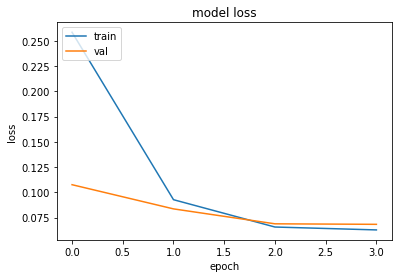

In [134]:
# plot training curves

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [166]:
# save model
model.save("/Users/Thomas/Downloads/emoji-predictor/model.h5")

### Testing

* On our test set

In [137]:
y_pred = model.predict(x_test)

In [164]:
for i in range(x_test.shape[0]):
    true_emojis = np.nonzero(y_test[i])
    true_emojis_graphics = [emoji_list[k] for k in true_emojis[0].tolist()]
    predicted_emoji = emoji_list[np.argmax(y_pred[i])]
    predicted_proba = max(y_pred[i])
    print("predicted ({0:.4f}):".format(predicted_proba), predicted_emoji, '  true:', true_emojis_graphics )
    print('\n**************************\n')
    print()

predicted (0.0611): 😭   true: ['🤮']

**************************


predicted (0.0676): 😭   true: ['😃']

**************************


predicted (0.0623): 😭   true: ['🤗']

**************************


predicted (0.0653): 😭   true: ['😉', '🤷']

**************************


predicted (0.0674): 😂   true: ['🚨']

**************************


predicted (0.0696): 😭   true: ['🥵']

**************************


predicted (0.0634): 😭   true: ['💙']

**************************


predicted (0.0642): 😭   true: ['🤧']

**************************


predicted (0.0648): 😭   true: ['🙏']

**************************


predicted (0.0644): 😭   true: ['👇']

**************************


predicted (0.0676): 😂   true: ['✅', '😃']

**************************


predicted (0.0725): 😭   true: ['😰']

**************************


predicted (0.0768): 😂   true: ['🎬']

**************************


predicted (0.0725): 😭   true: ['😱']

**************************


predicted (0.0743): 😭   true: ['📸']

**************************




* On any sentence

In [170]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
embedder = CamembertModel.from_pretrained('camembert-base')
classifier = keras.models.load_model("/Users/Thomas/Downloads/emoji-predictor/model.h5")

In [208]:
text = "J'adore la musique de Jul"
token_ids = torch.tensor(tokenizer.encode(clean(text))).unsqueeze(0)
embedding = embedder(token_ids)[0]
cls_embedding = np.matrix(embedding.squeeze()[0].detach().numpy())
pred = classifier.predict(cls_embedding)

In [210]:
with open('/Users/Thomas/Downloads/emoji-predictor/top100.txt') as f:
    emoji_list = ast.literal_eval(f.read())

top_emoji = emoji_list[np.argmax(pred)]
top3_emojis = [emoji_list[k] for k in np.argpartition(pred[0], -3)[-3:].tolist()]

print(top_emoji)
print(' '.join(top3_emojis))

😭
😅 😭 😂


In [220]:
with open('/Users/Thomas/Downloads/emoji-predictor/top100.txt') as f:
    emoji_list = ast.literal_eval(f.read())

top_emoji = emoji_list[np.argmax(pred)]
top3_emojis = [emoji_list[k] for k in np.argpartition(pred[0], -3)[-3:].tolist()]

print(top_emoji)
print(' '.join(top3_emojis))

😭
👍 😭 😂


In [225]:
top_proba = max(pred[0])
top3_proba = [pred[0][k] for k in np.argpartition(pred[0], -3)[-3:].tolist()]
print(top3_proba)

[0.04728341, 0.0711104, 0.061371326]


In [226]:
mod = keras.models.load_model("/Users/Thomas/Downloads/final.h5")

In [227]:
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               98432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                2